In [31]:
# Package import cell, data file read-in
# and conversion to all floats

import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import scipy as sp
from io import StringIO
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import collections

X = pd.read_csv('/users/Orion/NYU/tornado_v2/tornado-xtrain.csv', header=0, index_col='EVENT_ID')
y = pd.read_csv('/users/Orion/NYU/tornado_v2/tornado-ytrain.csv', header=None, index_col=0)
y.index.rename('EVENT_ID', inplace=True)

In [32]:
# Data scaling and splitting into features and target

X = X.astype(float)
X = preprocessing.scale(X)
y = y[1]

In [33]:
# Training train validation split 75:25;
# define and rebalance using SMOTE

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
sm = SMOTE(sampling_strategy='not majority')
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

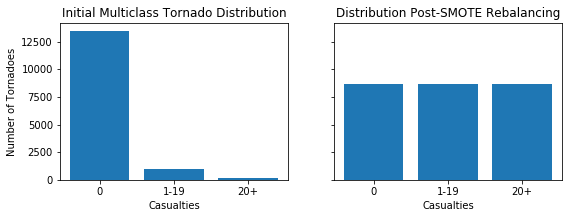

In [85]:
# Visualize multiclass redistribution using SMOTE

balanced_counts = collections.Counter(y_train_balanced)

mt = pd.read_csv('tornadoes-multiclass.csv', index_col='EVENT_ID')
mt = mt.astype(float)
mt_counts = mt['multiclass_casualties'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].bar(['0', '1-19', '20+'], mt_counts)
axs[0].set_xlabel('Casualties')
axs[0].set_ylabel('Number of Tornadoes')
axs[0].title.set_text('Initial Multiclass Tornado Distribution')
axs[1].bar(['0', '1-19', '20+'], balanced_counts.values())
axs[1].set_xlabel('Casualties')
axs[1].title.set_text('Distribution Post-SMOTE Rebalancing')
plt.subplots_adjust(top=0.85)
plt.show()

In [86]:
# Default Logistic Regression and evaluation

lr = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=200).fit(X_train_balanced, y_train_balanced)
lr_pred = lr.predict(X_val)
lr_prob = lr.predict_proba(X_val)[:,1]

lr_confusion = confusion_matrix(y_val, lr_pred)
lr_confusion_weighted = np.array([lr_confusion[i]/sum(lr_confusion[i]) for i in range(len(lr_confusion))])
lr_f1 = f1_score(y_val, lr_pred, average = 'weighted')

print('Confusion Matrix\n'+str(lr_confusion))
print('\nConfusion Matrix with Weights\n'+str(lr_confusion_weighted))
print('\nF1 Score\n'+str(lr_f1))

Confusion Matrix
[[1870  242   50]
 [  54   68   37]
 [   1    6   14]]

Confusion Matrix with Weights
[[0.86493987 0.1119334  0.02312673]
 [0.33962264 0.42767296 0.2327044 ]
 [0.04761905 0.28571429 0.66666667]]

F1 Score
0.8662608178627504


In [60]:
# Logistic Regression with built-in Cross-Validation

# cs = np.power(10, (np.arange(-8,2, dtype='float')))

lrcv = LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=10, max_iter=200, refit=False).fit(X_train_balanced, y_train_balanced)
lrcv_pred = lrcv.predict(X_val)
lrcv_prob = lrcv.predict_proba(X_val)[:,1]

lrcv_confusion = confusion_matrix(y_val, lrcv_pred)
lrcv_confusion_weighted = np.array([lrcv_confusion[i]/sum(lrcv_confusion[i]) for i in range(len(lrcv_confusion))])
lrcv_f1 = f1_score(y_val, lrcv_pred, average = 'macro')

print('Confusion Matrix\n'+str(lrcv_confusion))
print('\nConfusion Matrix with Weights\n'+str(lrcv_confusion_weighted))
print('\nF1 Score\n'+str(lrcv_f1))

/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Confusion Matrix
[[1883  231   48]
 [  55   70   34]
 [   1    7   13]]

Confusion Matrix with Weights
[[0.87095282 0.10684551 0.02220167]
 [0.34591195 0.44025157 0.21383648]
 [0.04761905 0.33333333 0.61904762]]

F1 Score
0.4807454683178225


In [61]:
lrcv.get_params

<bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='auto', n_jobs=None, penalty='l2',
           random_state=None, refit=False, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)>

In [37]:
# Default SVM and evaluation

svm = SVC(gamma='scale').fit(X_train_balanced, y_train_balanced)
svm_pred = svm.predict(X_val)

svm_confusion = confusion_matrix(y_val, svm_pred)
svm_confusion_weighted = np.array([svm_confusion[i]/sum(svm_confusion[i]) for i in range(len(svm_confusion))])
svm_f1 = f1_score(y_val, svm_pred, average='macro')

print('Confusion Matrix\n'+str(svm_confusion))
print('\nConfusion Matrix with Weights\n'+str(svm_confusion_weighted))
print('\nF1 Score\n'+str(svm_f1))

Confusion Matrix
[[1925  217   20]
 [  60   84   15]
 [   3   11    7]]

Confusion Matrix with Weights
[[0.89037928 0.10037003 0.00925069]
 [0.37735849 0.52830189 0.09433962]
 [0.14285714 0.52380952 0.33333333]]

F1 Score
0.5022069878949628


In [38]:
# Define cross-validation function for SVM

def xValSVM(X, y, k, cs):
    k_folds = sklearn.model_selection.KFold(n_splits=k)
    F1s = {}
    
    for train_index, test_index in k_folds.split(X):
        xtrain, xval = pd.DataFrame(X).iloc[train_index], pd.DataFrame(X).iloc[test_index]
        ytrain, yval = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[test_index]
        ytrain = np.asarray(ytrain).ravel()
        yval = np.asarray(yval).ravel()
        for c in cs:
            svm = sklearn.svm.SVC(gamma='scale', C=c).fit(xtrain, ytrain)
            svm_pred = svm.predict(xval)
            f1 = f1_score(yval, svm_pred, average='macro')
            F1s.setdefault(c, []).extend([f1])

    return F1s

In [39]:
# Run SVM through cross-validation function

cs = np.power(10, (np.arange(-8,2, dtype='float')))
F1s = xValSVM(X_train_balanced, y_train_balanced, 10, cs)

/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/p

/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/skl

/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/skl

/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/orion/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

In [45]:
# Select C hyperparameter for max F1 value

F1s = pd.DataFrame(F1s).transpose()
mean = F1s.mean()
F1s

,0,1,2,3,4,5,6,7,8,9
1.000000e-08,0.005103,0.006366,0.007625,0.002816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.000000e-07,0.005103,0.006366,0.007625,0.002816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.000000e-06,0.005103,0.006366,0.007625,0.002816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.000000e-05,0.005103,0.006366,0.007625,0.002816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.000000e-04,0.005103,0.006366,0.007625,0.002816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1.000000e-03,0.238272,0.275602,0.282273,0.488257,0.000000,0.000000,0.421111,0.225793,0.220444,0.217719
1.000000e-02,0.506578,0.543816,0.550477,0.497457,0.186348,0.187413,0.435636,0.279594,0.280027,0.274919
1.000000e-01,0.529395,0.557459,0.571283,0.514422,0.199712,0.197685,0.482774,0.299022,0.300035,0.293045
1.000000e+00,0.566941,0.621312,0.627787,0.598733,0.245554,0.251321,0.559408,0.330023,0.330350,0.329298
1.000000e+01,0.674739,0.713863,0.727642,0.757839,0.303959,0.304111,0.638720,0.499711,1.000000,0.499421


In [42]:
mean

1.000000e-08    0.002191
1.000000e-07    0.002191
1.000000e-06    0.002191
1.000000e-05    0.002191
1.000000e-04    0.002191
1.000000e-03    0.236947
1.000000e-02    0.374227
1.000000e-01    0.394483
1.000000e+00    0.446073
1.000000e+01    0.612000
dtype: float64

In [53]:
def xValSVM222(X, y, k, cs):
    k_folds = sklearn.model_selection.KFold(n_splits=k)
    F1s = {}
    
    for train_index, test_index in k_folds.split(X):
        xtrain, xval = pd.DataFrame(X).iloc[train_index], pd.DataFrame(X).iloc[test_index]
        ytrain, yval = pd.DataFrame(y).iloc[train_index], pd.DataFrame(y).iloc[test_index]
        ytrain = np.asarray(ytrain).ravel()
        yval = np.asarray(yval).ravel()
#         print(collections.Counter(ytrain))
        print(collections.Counter(yval))
        
F1s = xValSVM222(X_train_balanced, y_train_balanced, 10, cs)

Counter({0.0: 2419, 1.0: 154, 2.0: 20})
Counter({0.0: 2355, 1.0: 213, 2.0: 25})
Counter({0.0: 2386, 1.0: 177, 2.0: 30})
Counter({0.0: 1483, 1.0: 1099, 2.0: 11})
Counter({1.0: 2593})
Counter({1.0: 2593})
Counter({1.0: 1814, 2.0: 779})
Counter({2.0: 2593})
Counter({2.0: 2593})
Counter({2.0: 2592})
